# Project 2 Prediksi Saham Univariate

# Import Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import BaggingRegressor
from joblib import dump, load

# EDA

## Load Data

In [ ]:
df = pd.read_csv('data/BMRI_uni3.csv', sep=';')
df = df.reindex(index=df.index[::-1])

df.head()


,Date,Open
1459,12/03/2018,7550
1458,12/04/2018,7575
1457,12/05/2018,7600
1456,12/06/2018,7400
1455,12/07/2018,7575


## Info Data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 1459 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    1460 non-null   object
 1   Open    1460 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 22.9+ KB


## Null Value

In [5]:
df.isnull().sum()

Date    0
Open    0
dtype: int64

## Set date format

In [6]:
df = df[['Date', 'Open']]
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, format='%m/%d/%Y').dt.date
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df

,Open
Date,
2018-12-03,7550
2018-12-04,7575
2018-12-05,7600
2018-12-06,7400
2018-12-07,7575
...,...
2024-12-02,6175
2024-12-03,6100
2024-12-04,6275


## Plot Data

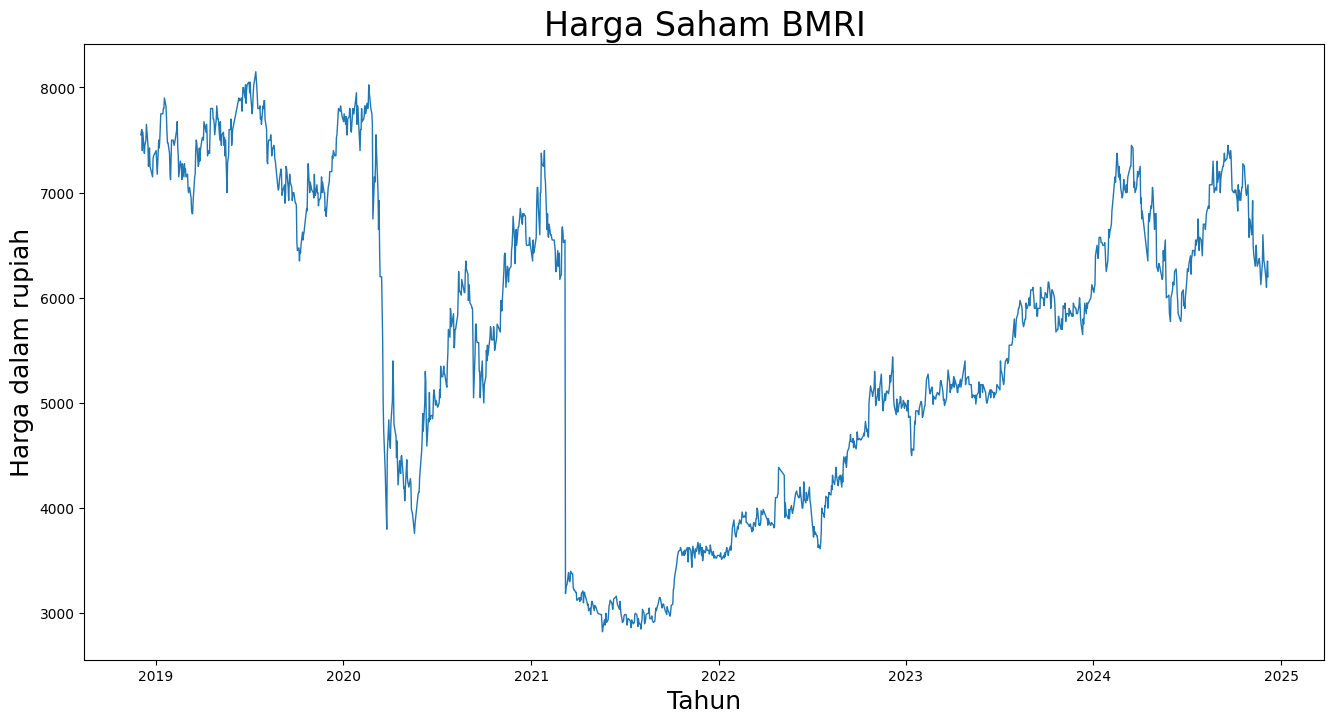

In [7]:
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Harga Saham BMRI", fontsize=24)
plt.ylabel('Harga dalam rupiah', fontsize=18)
plt.xlabel('Tahun', fontsize=18)
sns.set_palette(["#2419ef", "#19c4ef", "#EF5919"])
sns.lineplot(x='Date', y='Open', data=df, linewidth=1.0, dashes=False, ax=ax1)
plt.show()

## Histogram Data

array([[<Axes: title={'center': 'Open'}>]], dtype=object)

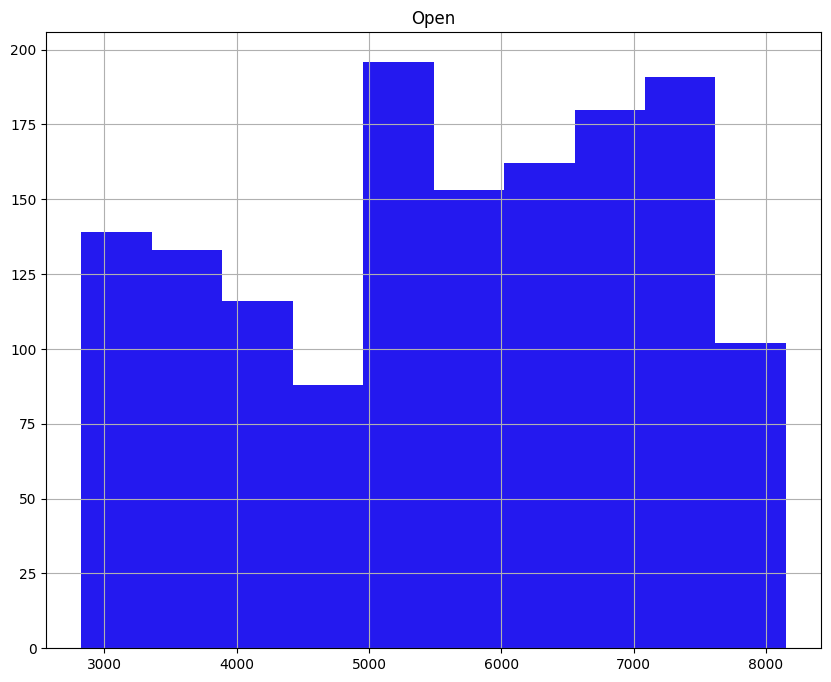

In [8]:
df.hist(figsize=(10, 8), column=['Open'])

## Boxplot Data

<Axes: >

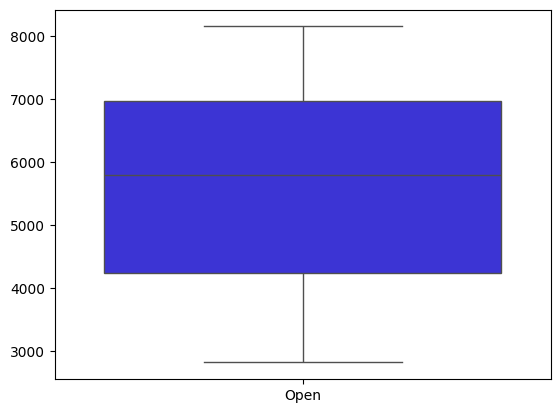

In [9]:
sns.boxplot(data=df)

# Prepocessing
## Normalize Data

In [10]:
def normalize_data(data):
    scaler = MinMaxScaler()
    normalized_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
    csv = {
        'Date': data.index,
        'Open': data['Open'].values,
        'normalized_Pembukaan': normalized_data['Open'].values
        
    }
    csv = pd.DataFrame(csv)
    return normalized_data, scaler, csv


normalized_df, scaler, csv_normalized = normalize_data(df)
csv_normalized.to_csv('normalized_data.csv', index=False)
dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [100]:
normalized_df

,Open
Date,
2018-12-03,0.887324
2018-12-04,0.892019
2018-12-05,0.896714
2018-12-06,0.859155
2018-12-07,0.892019
...,...
2024-12-02,0.629108
2024-12-03,0.615023
2024-12-04,0.647887


In [101]:
def denormalize_data(data, scaler):
    return pd.DataFrame(scaler.inverse_transform(data), columns=data.columns, index=data.index)

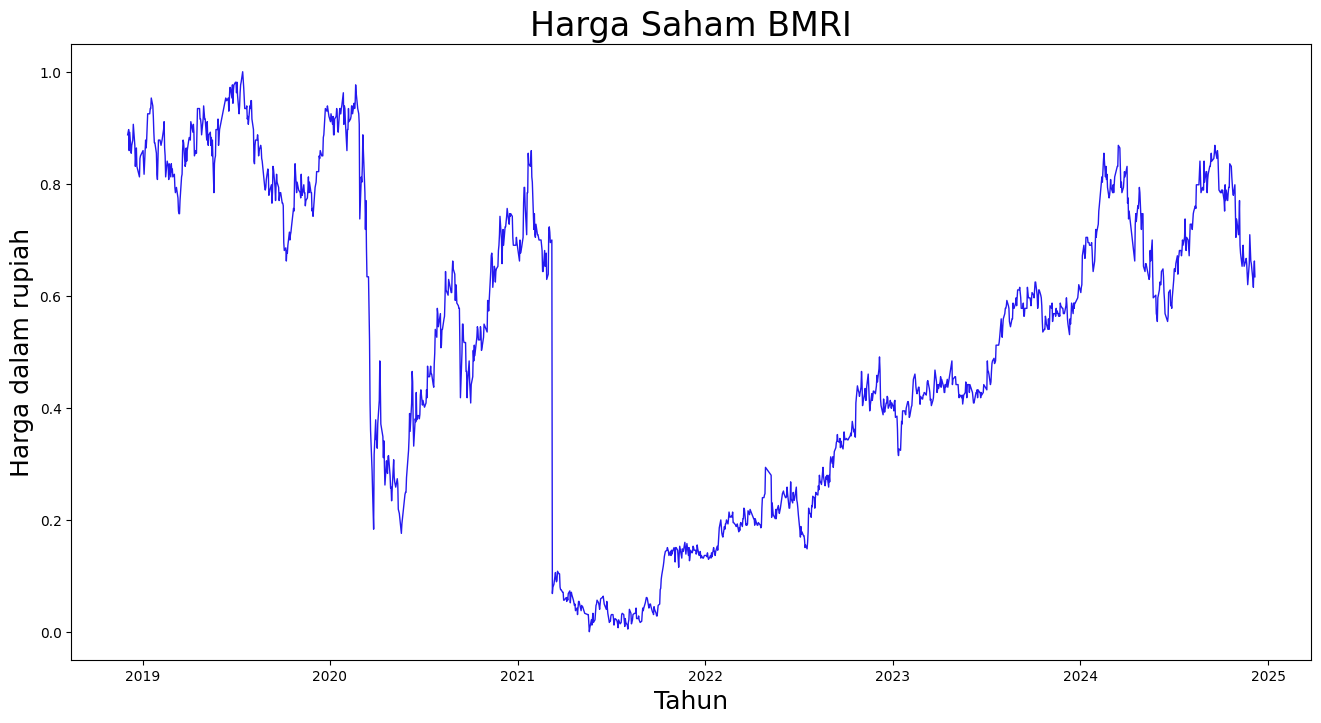

In [115]:
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Harga Saham BMRI", fontsize=24)
plt.ylabel('Harga dalam rupiah', fontsize=18)
plt.xlabel('Tahun', fontsize=18)
sns.set_palette(["#2419ef", "#19c4ef", "#EF5919"])
sns.lineplot(x='Date', y='Open', data=normalized_df, linewidth=1.0, dashes=False, ax=ax1)
plt.show()

## Create Data Lag

In [103]:
def sliding_window(data, lag):
    series = data['Open']
    result = pd.DataFrame()
    for l in range(1, lag+1):
        result[f'open-{l}'] = series.shift(l)

    result['open'] = series[l:]
    result = result.dropna()
    result.index = series.index[l:]
    return result

lag = 5
windowed_data = sliding_window(normalized_df, lag)
windowed_data = windowed_data[[f'open'] + [f'open-{i}' for i in range(1, lag+1)]]
print(windowed_data)

                open    open-1    open-2    open-3    open-4    open-5
Date                                                                  
2018-12-10  0.854460  0.892019  0.859155  0.896714  0.892019  0.887324
2018-12-11  0.868545  0.854460  0.892019  0.859155  0.896714  0.892019
2018-12-12  0.873239  0.868545  0.854460  0.892019  0.859155  0.896714
2018-12-13  0.877934  0.873239  0.868545  0.854460  0.892019  0.859155
2018-12-14  0.906103  0.877934  0.873239  0.868545  0.854460  0.892019
...              ...       ...       ...       ...       ...       ...
2024-12-02  0.629108  0.657277  0.661972  0.708920  0.657277  0.619718
2024-12-03  0.615023  0.629108  0.657277  0.661972  0.708920  0.657277
2024-12-04  0.647887  0.615023  0.629108  0.657277  0.661972  0.708920
2024-12-05  0.661972  0.647887  0.615023  0.629108  0.657277  0.661972
2024-12-06  0.633803  0.661972  0.647887  0.615023  0.629108  0.657277

[1455 rows x 6 columns]


## Split Data

In [104]:
def split_data(data, target, train_size):
    split_index = int(len(data) * train_size)

    x_train = data[:split_index]
    y_train = target[:split_index]
    x_test = data[split_index:]
    y_test = target[split_index:]

    return x_train, y_train, x_test, y_test

input_df = windowed_data[[f'open-{i}' for i in range(1, lag + 1)]]
target_df = windowed_data[['open']]

x_train, y_train, x_test, y_test = split_data(input_df, target_df, 0.8)

print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)




X_train shape: (1164, 5)
y_train shape: (1164, 1)
X_test shape: (291, 5)
y_test shape: (291, 1)


# Modelling

## Modelling Data

In [105]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)

y_pred = linear_model.predict(x_test)

In [ ]:
dump(linear_model, 'linear_model.lib')

In [106]:
from sklearn.metrics import r2_score, mean_absolute_error


mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 0.000518244711240929
Mean Absolute Error (MAE): 0.017241713867736774
Mean Absolute Percentage Error (MAPE): 0.025013062165712713
R-squared (R2): 0.9425825957581898


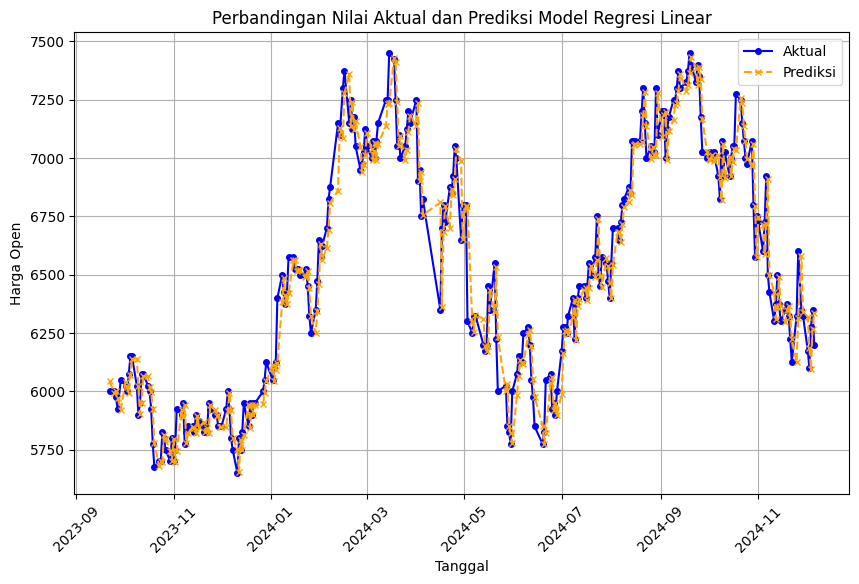

In [107]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, scaler.inverse_transform(y_test), label='Aktual', color='blue', marker='o', linestyle='-', markersize=4)
plt.plot(y_test.index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Prediksi', color='orange', marker='x', linestyle='--', markersize=4)
plt.title('Perbandingan Nilai Aktual dan Prediksi Model Regresi Linear')
plt.xlabel('Tanggal')
plt.ylabel('Harga Open')
plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Testing

In [ ]:
last_row = windowed_data.iloc[-1][[f'open-{i}' for i in range(1, lag+1) ]].values.reshape(1, -1)
predicted_value_normalized = linear_model.predict(last_row)
predicted_value = scaler.inverse_transform(predicted_value_normalized.reshape(-1, 1))

last_price = scaler.inverse_transform(normalized_df[['Open']].iloc[-1].values.reshape(-1, 1))
percentage_change = ((predicted_value[0][0] - last_price[0][0]) / last_price[0][0]) * 100

if percentage_change > 0:
    change_sign = '+'
else:
    change_sign = ''

print(f'Harga BMRI Hari ini: {last_price[0][0]}')
print(f'Prediksi Harga BMRI Besok: {predicted_value[0][0]} ({change_sign}{percentage_change:.2f}%)')

Prediksi Harga Saham BMRI pada Tanggal 2024-12-06: 6337.081642272639 (+2.21%)
Harga BMRI Hari ini: 6200.0
Prediksi Harga BMRI Besok: 6337.081642272639 (+2.21%)


c:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


# Deploy

https://huggingface.co/spaces/Rieko00/BMRI_Uni